# Task 2
## Prediction of m6A sites in all SG-NEx direct RNA-Seq samples 
<ul>
<li> Predict m6A RNA modifications in all samples from the SG-NEx data using our own method </li>
<li> Describe the results and compare them across the different cell lines </li>
<li> Summarise and visualise your observations </li>
</ul>

<b>Submission</b>: Describe the results and compare them across the different cell lines. Summarise and visualise your observations.

# Importing modules and functions

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import joblib
import numpy as np
import torch
import torch.nn as nn
import sys
import os

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

In [2]:
%run "../code/data_agg_mean.py"

In [3]:
%run "../code/feature_eng_pipeline.py"

# Loading and processing the dataset 

In [4]:
# A549 Lung cell line 
a549_rep5_df = pd.read_csv("../dataset/CSV/A549_replicate5_data.csv") # change input path accordingly 
a549_rep6_df = pd.read_csv("../dataset/CSV/A549_replicate6_data.csv")

# HCT116 Colon cell line
hct116_rep3_df = pd.read_csv("../dataset/CSV/HCT116_replicate3_data.csv")
hct116_rep3_run4_df = pd.read_csv("../dataset/CSV/HCT116_replicate3_run4_data.csv")
hct116_rep4_run3_df = pd.read_csv("../dataset/CSV/HCT116_replicate4_run3_data.csv")

# HepG2 Liver cell line
hepg2_rep5_df = pd.read_csv("../dataset/CSV/hepG2_replicate5_data.csv")
hepg2_rep6_df = pd.read_csv("../dataset/CSV/hepG2_replicate6_data.csv")

# K562 Leukocytes cell line
k562_rep4_df = pd.read_csv("../dataset/CSV/k562_replicate4_data.csv")
k562_rep5_df = pd.read_csv("../dataset/CSV/k562_replicate5_data.csv")
k562_rep6_df = pd.read_csv("../dataset/CSV/k562_replicate6_data.csv")

# MCF7 Breast cell line
mcf7_rep3_df = pd.read_csv("../dataset/CSV/mcf7_replicate3_data.csv")
mcf7_rep4_df = pd.read_csv("../dataset/CSV/mcf7_replicate4_data.csv")

# List of orig df 
orig_df_list = [a549_rep5_df, a549_rep6_df, hct116_rep3_df, hct116_rep3_run4_df, hct116_rep4_run3_df, hepg2_rep5_df,
                hepg2_rep6_df, k562_rep4_df, k562_rep5_df, k562_rep6_df, mcf7_rep3_df, mcf7_rep4_df ]

Aggregated dataset based on mean 

In [5]:
# A549 Lung cell line
a549_df = data_agg_mean(pd.concat([a549_rep5_df, a549_rep6_df], axis = 0))

# HCT116 Colon cell line
hct116_df = data_agg_mean(pd.concat([hct116_rep3_df, hct116_rep3_run4_df, hct116_rep4_run3_df], axis = 0))

# HepG2 Liver cell line
hepg2_df = data_agg_mean(pd.concat([hepg2_rep5_df, hepg2_rep6_df], axis = 0))

# K562 Leukocytes cell line
k562_df = data_agg_mean(pd.concat([k562_rep4_df, k562_rep5_df, k562_rep6_df], axis = 0))

# MCF7 Breast cell line
mcf7_df = data_agg_mean(pd.concat([mcf7_rep3_df, mcf7_rep4_df], axis = 0))

# List of agg df
agg_df_list = [a549_df, hct116_df, hepg2_df, k562_df, mcf7_df]

# Loading the NN Model

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [10]:
class ModNet(nn.Module):
    def __init__(self, signal_input_dim):
        super(ModNet, self).__init__()

        # Read-level Encoder: MLP with two hidden layers
        self.encoder = nn.Sequential(
            nn.Linear(signal_input_dim, 150),  # Change hidden dimensions as needed
            nn.ReLU(),
            nn.Linear(150, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Single output for binary classification
        )

    def forward(self, signal_features):
        read_level_probs = self.encoder(signal_features)
        return torch.sigmoid(read_level_probs)  # Apply sigmoid for probabilities

    def noisy_or_pooling(self, read_level_probs):
        """
        :param read_level_probs: Tensor of shape (batch_size, 1)
        :return: Site-level modification probability for each site (batch_size, 1)
        """
        site_level_probs = 1 - torch.prod(1 - read_level_probs, dim=1)
        return site_level_probs

In [11]:
class NewRNANanoporeDataset(Dataset):
    """Dataset to predict new (non training) RNA Nanopore data"""

    def __init__(self, df, vectorizer, standardizer):
        """Initializes instance of class NewRNANanoporeDataset.

        Args:
            # csv_file (str): Path to the csv file with the nanopore data
            Changed to df instead 
        """
        
        self.df = df
        X_df = process_new_data(df, vectorizer, standardizer) 

        # keep all trigram columns in input dataset
        self.X = X_df

    def __len__(self):
        """Returns the size of the dataset"""
        return len(self.X)

    def __getitem__(self, idx):
    # Handle if idx is a tensor (converting to list if needed)
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        signal_features = self.X.iloc[idx].values  

        # Convert to tensors
        signal_features = torch.tensor(signal_features, dtype=torch.float32)

        return signal_features
    
    def get_size(self):
        return len(self)

In [41]:
def predict_on_new_dataset(model, dataset, batch_size=32, device='cuda'):
    """
    Make predictions on new dataset/dataset without labels
    
    Args:
        model: trained PyTorch model
        dataset: any unlabelled dataset
        batch_size: batch size for DataLoader
        device: device to run predictions on
    
    Returns:
        tuple: (predictions, probabilities)
    """
    # Create DataLoader for full dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Set model to evaluation mode
    model.eval()
    model = model.to(device)
    
    # Lists to store predictions
    all_predictions = []
    all_probs = []
    
    print("Making predictions on dataset...")
    
    with torch.no_grad():
        for data in dataloader:
            signal_features = data
            
            # Move data to device
            signal_features = signal_features.to(device)
            
            # Forward pass
            read_level_probs = model(signal_features)
            site_level_probs = model.noisy_or_pooling(read_level_probs) # Remove .squeeze

            # Added 28/10
            if site_level_probs.dim() > 1:
                site_level_probs = site_level_probs.squeeze()
      
            predictions = (site_level_probs > 0.5).float()
           

            all_predictions.append(predictions.cpu())
            all_probs.append(site_level_probs.cpu())

    # Concatenate all predictions and labels
    predictions = torch.cat(all_predictions)
    probabilities = torch.cat(all_probs)

    return predictions, probabilities

In [13]:
def load_saved_model(model, save_dir="../models/", pth_file="model.pth"):
    """
    Load a saved model
    
    Args:
        model: Initialized model instance
        save_dir (str): directory where model is saved
        pth_file (str): name of the model file
    
    Returns:
        model: Loaded model
    """
    # Load checkpoint
    model_path = os.path.join(save_dir, pth_file)
    checkpoint = torch.load(model_path)
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Model loaded from {model_path}")
    return model

# Descriptive analytics 

## 1. Illustrate the approach 
Shows the data processing and analysis approach 

## 2. Relative location of m6A along mRNAs 
Lecture mentioned: Metagene plot to show the relative position of detected m6A sites across all transcripts. m6A expected to occur between the coding sequence and 3' UTR 

## 3. Analyse the features that we are using
Which features differ between modified and unmodified sites? Does this look similar across the cell lines? 

In [43]:
v,s,a,b = pipeline_nn(pd.read_csv("../dataset/mean_with_labels.csv"))

# To Check 
new_dataset = NewRNANanoporeDataset(a549_df, v, s)
model = ModNet(signal_input_dim=len(new_dataset.X.columns)) 

loaded_model = load_saved_model(
    model = model,  # Replace with your model class
    save_dir="../models/",
    pth_file="model3.pth"
)

Model loaded from ../models/model3.pth


C:\Users\lisal\AppData\Local\Temp\ipykernel_33456\1873487355.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [44]:
def probability_df(df, model, cell_line_name, v, s):
    """
    This function will add two new columns into the original df - labels and cell_line. 
    The labels column would contain the predicted labels of either 0 - no modification or 1 - modification.
    The cell_line column would contain the name of the cell_line that we are looking at.

    Inputs:
        1. df: dataframe of the pre-processed unlabelled dataset 
        2. model: the model that we are using for prediction
        3. cell_line_name: the name of the cell_line of this dataset 
        4. v: vectoriser obtained from the training dataset0
        5. s: standardiser obtained from the training dataset0

    Output:
        1. labelled_df: dataframe containing the two new columns - labels and cell_line
    """
    new_dataset = NewRNANanoporeDataset(df, v, s)

    # Update the df with the new label
    labelled_df = df.copy()
    predictions, probabilities = predict_on_new_dataset(
        model=model,
        dataset=new_dataset,
        batch_size=32,
        device=device
    )
    labelled_df['labels'] = predictions.numpy().tolist()

    # Update the df with the cell line name for use in boxplot 
    labelled_df["cell_line"] = cell_line_name

    return labelled_df

In [45]:
df_list = [a549_df, hct116_df, hepg2_df, k562_df, mcf7_df]
cell_line_list = ['A549', 'HCT116', 'HEPG2', 'K562', 'MCF7']
merged_df = probability_df(df_list[0], loaded_model, cell_line_list[0], v, s)
print("Merged A549")

for i in range(1,len(df_list)):
    prob_df = probability_df(df_list[i], loaded_model, cell_line_list[i], v, s)
    merged_df = pd.concat([prob_df, merged_df], axis = 0) 
    print(f"Merged {cell_line_list[i]}")

Making predictions on dataset...
Making predictions on dataset...
Merged HCT116
Making predictions on dataset...
Merged HEPG2
Making predictions on dataset...
Merged K562
Making predictions on dataset...
Merged MCF7


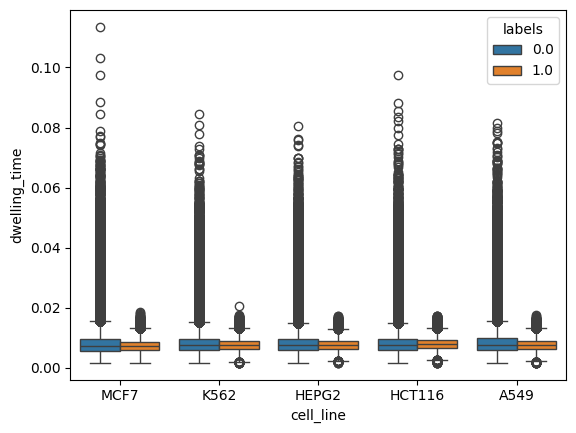

In [46]:
sns.boxplot(x = 'cell_line', y = 'dwelling_time', hue = 'labels', data = merged_df)
plt.show()

## 4. Compare m6A across all cell lines 
Do you observe that m6A is similar between cell lines, or different?

Which cell lines are more similar?

How many sites are shared, how many are unique?

## 5. Investigate individual sites/ genes 
Which genes are highly modified?

Which genes show differences across cell lines?

Visualise results for individual genes 